# GMVAE

This notebook attempts to implement the GMVAE which assumes the latent of a VAE is sampled from
- Sampled data can take $k$ different classes $\mathcal{C}=\{1,2,\dots,k\}$.
- The prior is modeled by two latent components $c\in\mathcal{C}$ and $\mathbf{z}\in\R^s$ instead of just $\mathbf{z}$
- Given $p(c;\theta)\sim\text{Categorical}(\mathcal{C})$ (assumed to be of equal probability) and $p(\mathbf{z}_1;\theta)\sim\mathbf{N}(\mathbf{0},\mathbf{I_s})$, we model $\mathbf{z}_2$ as a Gaussian Mixture Model where the class weights are $p(c;\theta)$ with means $\mu_\theta(\mathbf{z}_1)$ and covariances $\text{diag}(\sigma^2_\theta(\mathbf{z}_1))$ conditioned on $\mathbf{z}_1$, that is, $\mathbf{z}_2|\mathbf{z}_1,c$ is a Gaussian Mixture Model.
- Likewise, we aim to learn $p(\mathbf{x},\mathbf{z}_1,c,\mathbf{z}_2;\theta)$ and the corresponding $q(\mathbf{z}_1,c,\mathbf{z}_2|\mathbf{x};\phi)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
import torchvision
import torchvision.datasets as datasets
import math

#for consistency, all seeds are set to 69420
seed = 69420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

use MNIST as always

<Figure size 640x480 with 0 Axes>

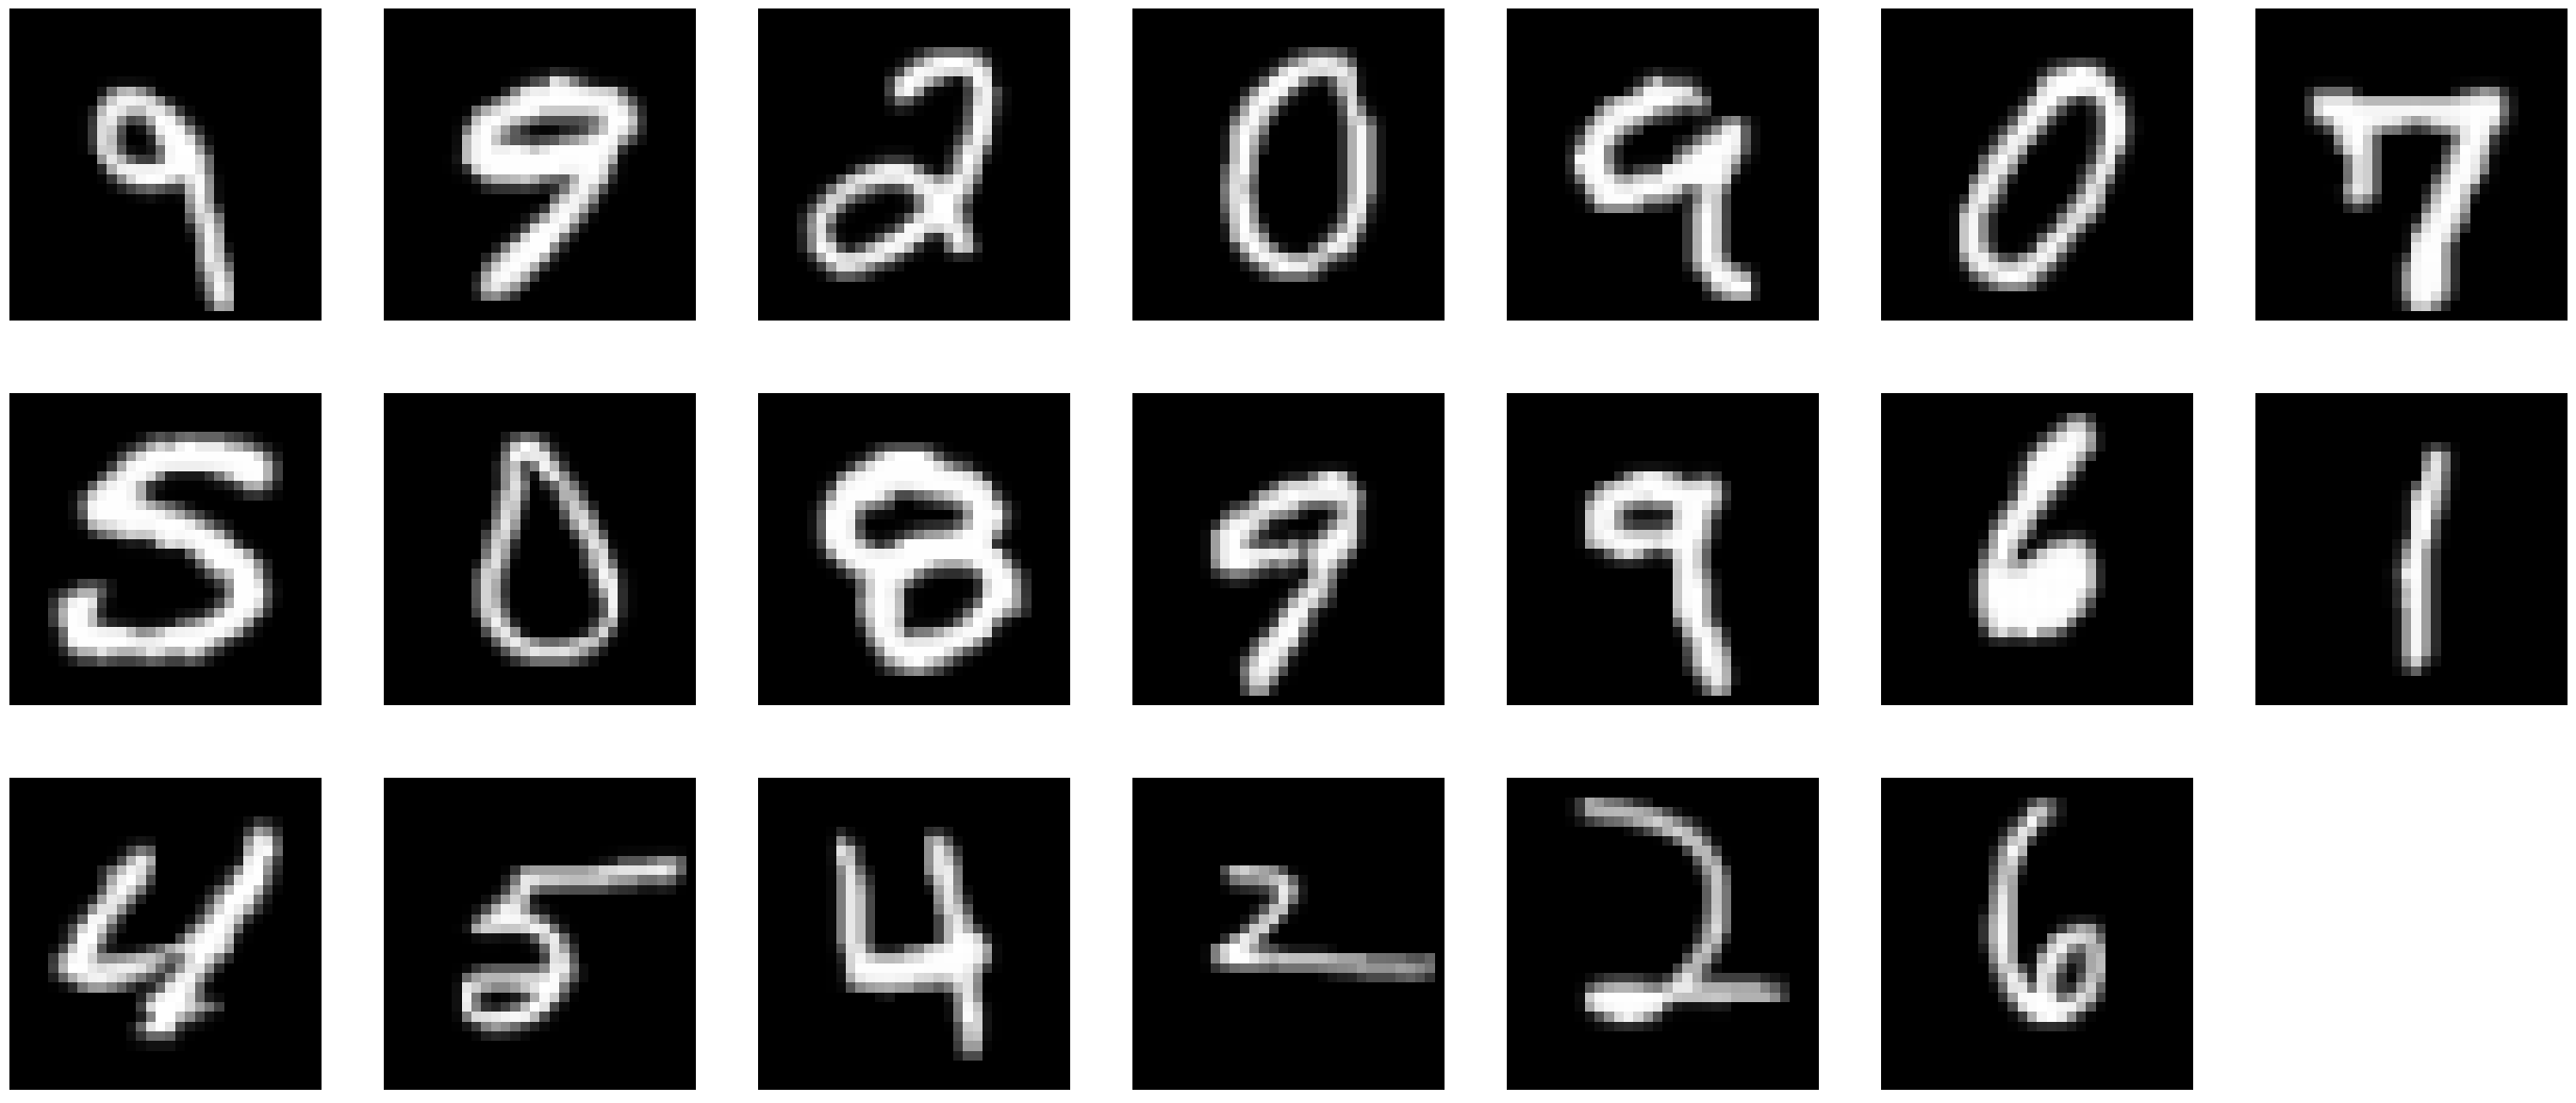

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
data_loader = torch.utils.data.DataLoader(mnist_trainset,batch_size=128,shuffle=True,num_workers=1)

plt.gray()

def plotter(images):
    f = -(-len(images)//3)
    fig,ax = plt.subplots(3,f,figsize=(5*f, 15))
    for i in range(len(images)):
        ax[i%3,i//3].imshow(images[i,0])
    for aa in ax:
        for aaa in aa:
            aaa.axis("off")
    plt.show()

for a, b in data_loader:
    plotter(a[0:20])
    break


## Encoder

The encoder follows this KL divergence formulation by the authors

\begin{align*}
    \mathrm{ELBO}(\mathbf{x},\theta,\phi)
    &= \mathbb{E}_{c \sim q(c \mid \mathbf{x}; \phi)}\bigl[\log p(\mathbf{x} \mid c; \theta)\bigr] \\[6pt]
    &\quad
    - \mathbb{E}_{\mathbf{z}_1,\,c \sim q(\mathbf{z}_1 \mid \mathbf{x}; \phi)\,p(c \mid \mathbf{z}_2,\mathbf{z}_1; \theta)}
    \bigl[D_{\mathrm{KL}}\bigl(q(c \mid \mathbf{z}_2,\mathbf{x}; \phi),\,p(c \mid \mathbf{z}_2,\mathbf{z}_1; \theta)\bigr)\bigr] \\[6pt]
    &\quad
    - D_{\mathrm{KL}}\bigl(q(\mathbf{z}_1 \mid \mathbf{x}; \phi),\,p(\mathbf{z}_1)\bigr) \\[6pt]
    &\quad
    - \mathbb{E}_{c,\,\mathbf{z}_1 \sim q(c \mid \mathbf{x}; \phi)\,q(\mathbf{z}_1 \mid \mathbf{x}; \phi)}
    \bigl[D_{\mathrm{KL}}\bigl(p(c \mid \mathbf{z}_2,\mathbf{z}_1; \theta),\,p(c \mid \mathbf{z}_2; \theta)\bigr)\bigr]
\end{align*}

basically the classes $c$ are not given but rather inferred from the other components

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z1_dim, z2_dim, img_channel, n_components):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # q(z1 | x) parameters
        self.mu_z1_fc = nn.Conv2d(256, z1_dim, 2, 1, 0, bias=False) #mu(x)
        self.var_z1_fc = nn.Conv2d(256, z1_dim, 2, 1, 0, bias=False) #sigma(x)

        # q(z2 | x) parameters
        self.mu_z2_fc = nn.Conv2d(256, z2_dim, 2, 1, 0, bias=False)
        self.var_z2_fc = nn.Conv2d(256, z2_dim, 2, 1, 0, bias=False)

        # p(z2 | z1), produces a mixture of gaussians
        self.z2_comp_mu = nn.Linear(z1_dim, n_components*z2_dim)
        self.z2_comp_var = nn.Linear(z1_dim, n_components*z2_dim)

        self.n_components = n_components
        self.z2_dim = z2_dim
        
        self.kl_z1, self.kl_z2c, self.kl_c = None, None, None

    def forward(self, x, normal_generator, temperature=1.0):
        B = x.shape[0]
        K = self.n_components
        D = self.z2_dim
        encoded = self.encoder(x)
        
        # step 1: z1~q(z1|x)
        mu_z1 = self.mu_z1_fc(encoded).mean([-2,-1])
        sigma_z1 = torch.exp(self.var_z1_fc(encoded)).mean([-2,-1])
        z1 = mu_z1 + sigma_z1*normal_generator.sample(mu_z1.shape)

        # step 2: z2~p(z2|z1)
        component_mu = self.z2_comp_mu(z1).reshape(B, self.n_components, self.z2_dim)
        component_sigma = torch.exp(self.z2_comp_var(z1)).reshape(B, self.n_components, self.z2_dim)
        
        # step 3: z2~q(x2|x)
        mu_z2 = self.mu_z2_fc(encoded).mean([-2,-1])
        sigma_z2 = torch.exp(self.var_z2_fc(encoded)).mean([-2,-1])
        z2 = mu_z2 + sigma_z2*normal_generator.sample(mu_z2.shape)

        # step 4: c~p(c|z2,z1)
        log_prob_k = -0.5*(
            ((z2.unsqueeze(1)-component_mu)**2) / (component_sigma**2)
            + 2*torch.log(component_sigma)
            + math.log(2*math.pi)
        ).sum(-1)
        log_pi = math.log(1.0 / self.n_components) # assume c starts of equal/uniform
        logits_c = log_pi + log_prob_k
        c_onehot = torch.nn.functional.gumbel_softmax(logits_c, tau=temperature, hard=True)
        
        # step 5: compute KL losses
        kl_z1 = 0.5*torch.sum(sigma_z1**2+mu_z1**2-2*torch.log(sigma_z1)-1)
        kl_z2c = 0.5 * torch.sum(
            c_onehot.unsqueeze(-1) * (
                2 * torch.log(component_sigma)  # log det z2_sigma from p
                - 2 * torch.log(sigma_z2).unsqueeze(1)  # log det z2_sigma from q
                + ((sigma_z2**2).unsqueeze(1) + (mu_z2.unsqueeze(1) - component_mu)**2)
                / (component_sigma**2)
                - 1
            ), dim=(1, 2)
        ).sum() # 全然分からない、この宇宙の魔法 but somehow this learns z2
        probs_c = (logits_c-logits_c.logsumexp(1, keepdim=True)).exp()
        kl_c = torch.sum(probs_c*(logits_c - math.log(1/self.n_components)), dim=1).sum()
        
        self.kl_z1, self.kl_z2c, self.kl_c = kl_z1, kl_z2c, kl_c
        return z1, c_onehot, z2 

## Decoder

We use the same decoder architecture

In [9]:
class Decoder(nn.Module):
    
    def __init__(self, latent_size, img_channel):
        
        super(Decoder, self).__init__()

        self.conv_transpose_block_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_5 = nn.Sequential(
            nn.ConvTranspose2d(32, img_channel, 1, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        x = self.conv_transpose_block_1(x)
        x = self.conv_transpose_block_2(x)
        x = self.conv_transpose_block_3(x)
        x = self.conv_transpose_block_4(x)
        x = self.conv_transpose_block_5(x)
        return x

## VAE training
We train the VAE like normal albeit with more KL terms. We will show how conditional generation works in the inference step.

In [13]:
latent_size = 128
img_ch = 1
num_epochs = 20
n_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normal_generator = torch.distributions.Normal(torch.tensor(0).float().to(device), torch.tensor(1).float().to(device))

enc = Encoder(latent_size, latent_size, img_ch, n_classes).to(device)
dec = Decoder(latent_size, img_ch).to(device)

optimizer = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=0.0002, betas=(0.5, 0.999))

0it [00:00, ?it/s]

Iter 469/469 [Epoch 1/20] KL_z1 = 13.4299  KL_z2c = 40.4260  KL_c = -186.9172  L2 = 75.6158: : 469it [00:11, 42.18it/s]


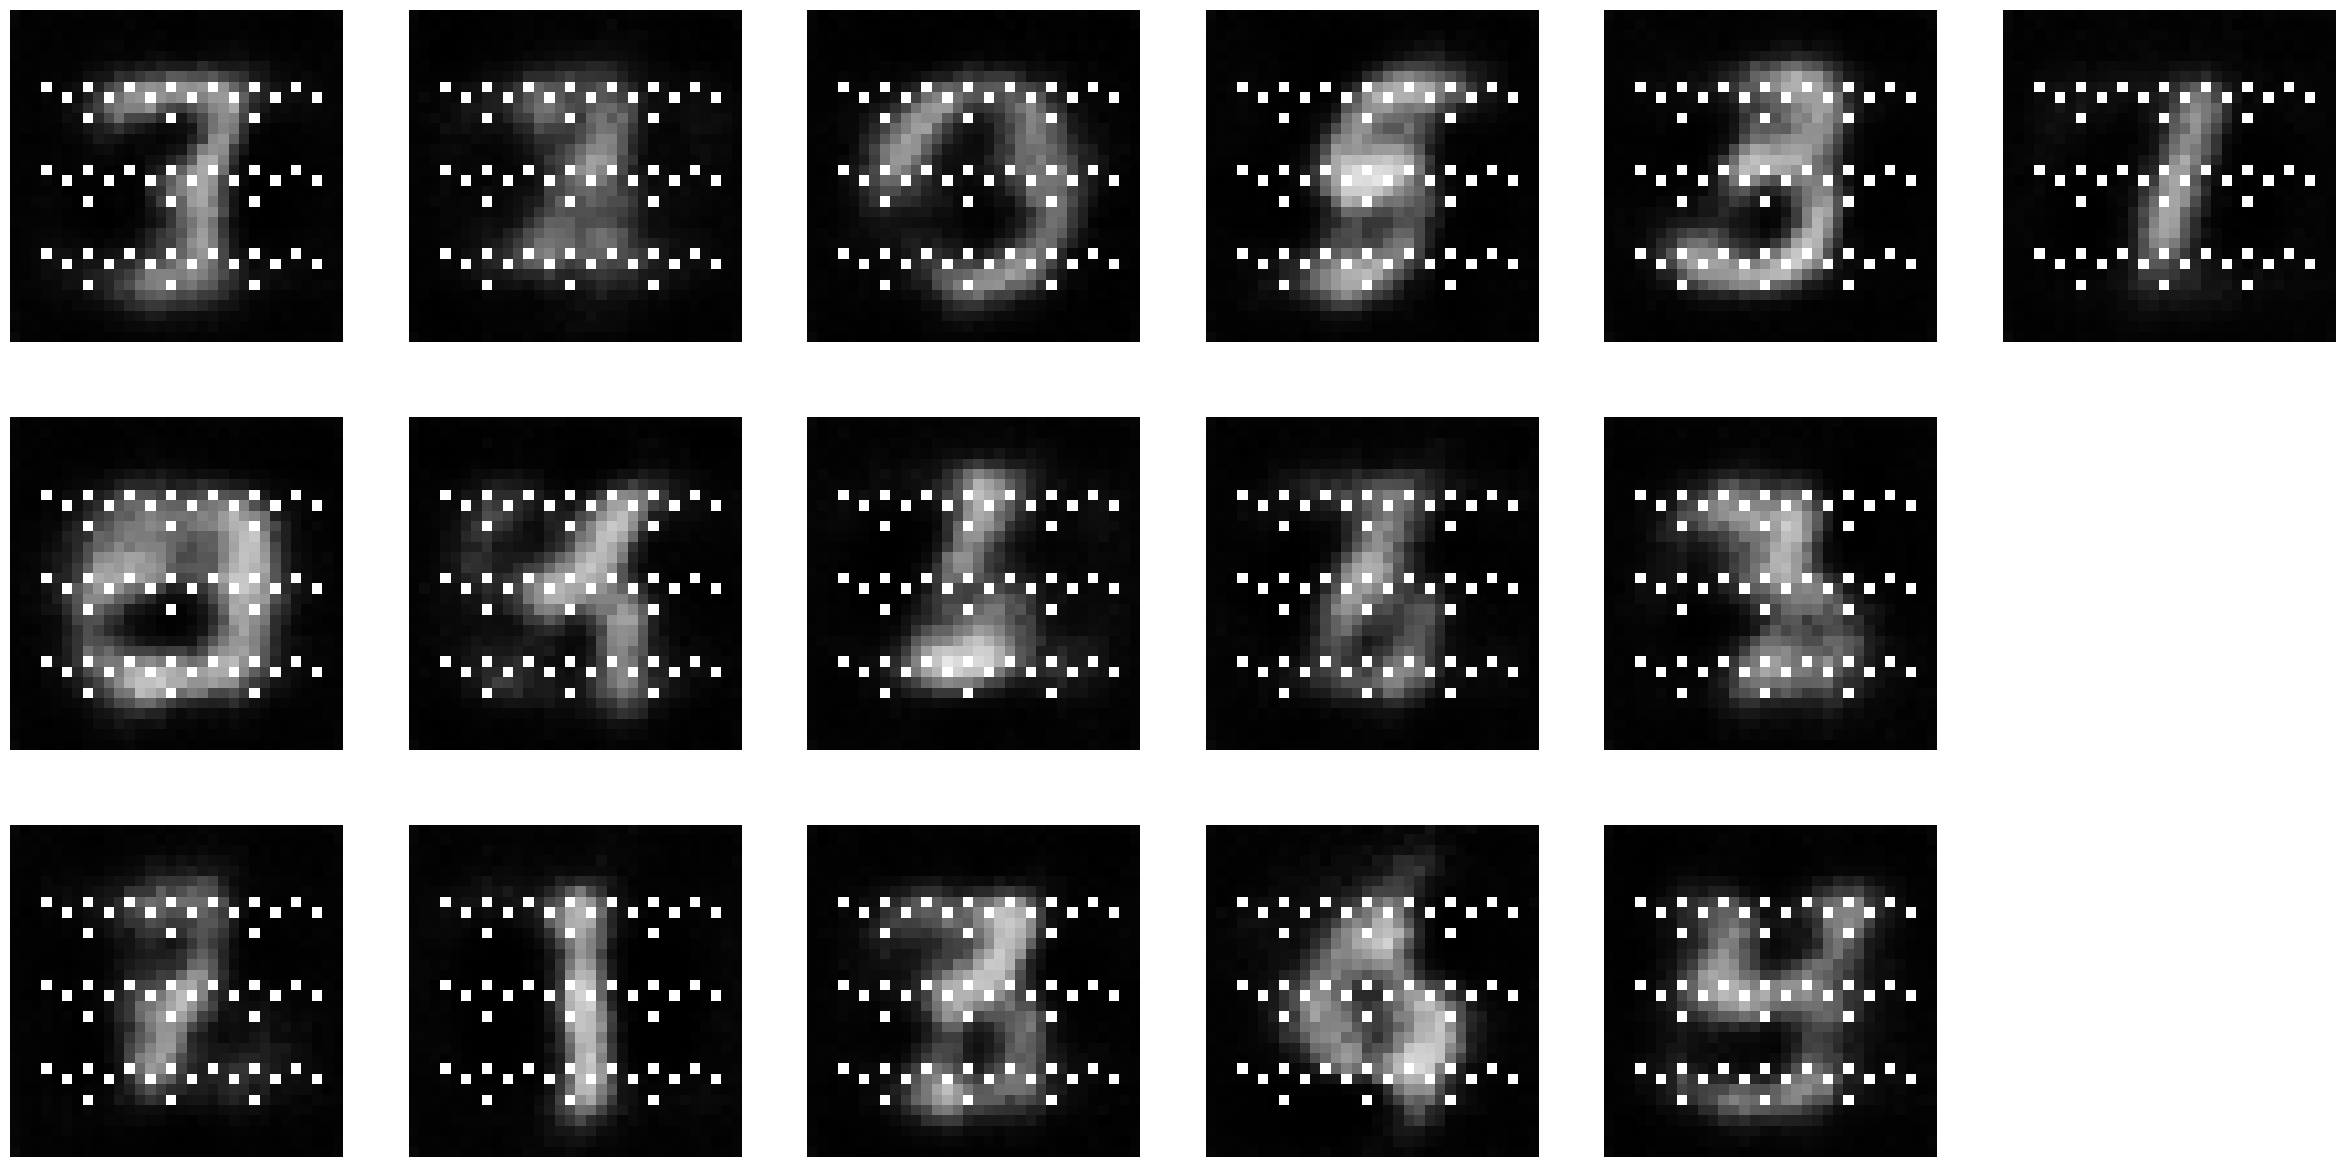

Iter 469/469 [Epoch 2/20] KL_z1 = 4.2342  KL_z2c = 15.6245  KL_c = -190.7234  L2 = 62.2313: : 469it [00:10, 44.36it/s]
Iter 469/469 [Epoch 3/20] KL_z1 = 3.9659  KL_z2c = 9.6731  KL_c = -187.9333  L2 = 58.8438: : 469it [00:10, 42.82it/s] 
Iter 469/469 [Epoch 4/20] KL_z1 = 3.9389  KL_z2c = 9.3278  KL_c = -187.3968  L2 = 56.7937: : 469it [00:09, 47.12it/s]
Iter 469/469 [Epoch 5/20] KL_z1 = 3.9439  KL_z2c = 9.5096  KL_c = -186.9524  L2 = 55.3275: : 469it [00:09, 48.39it/s]


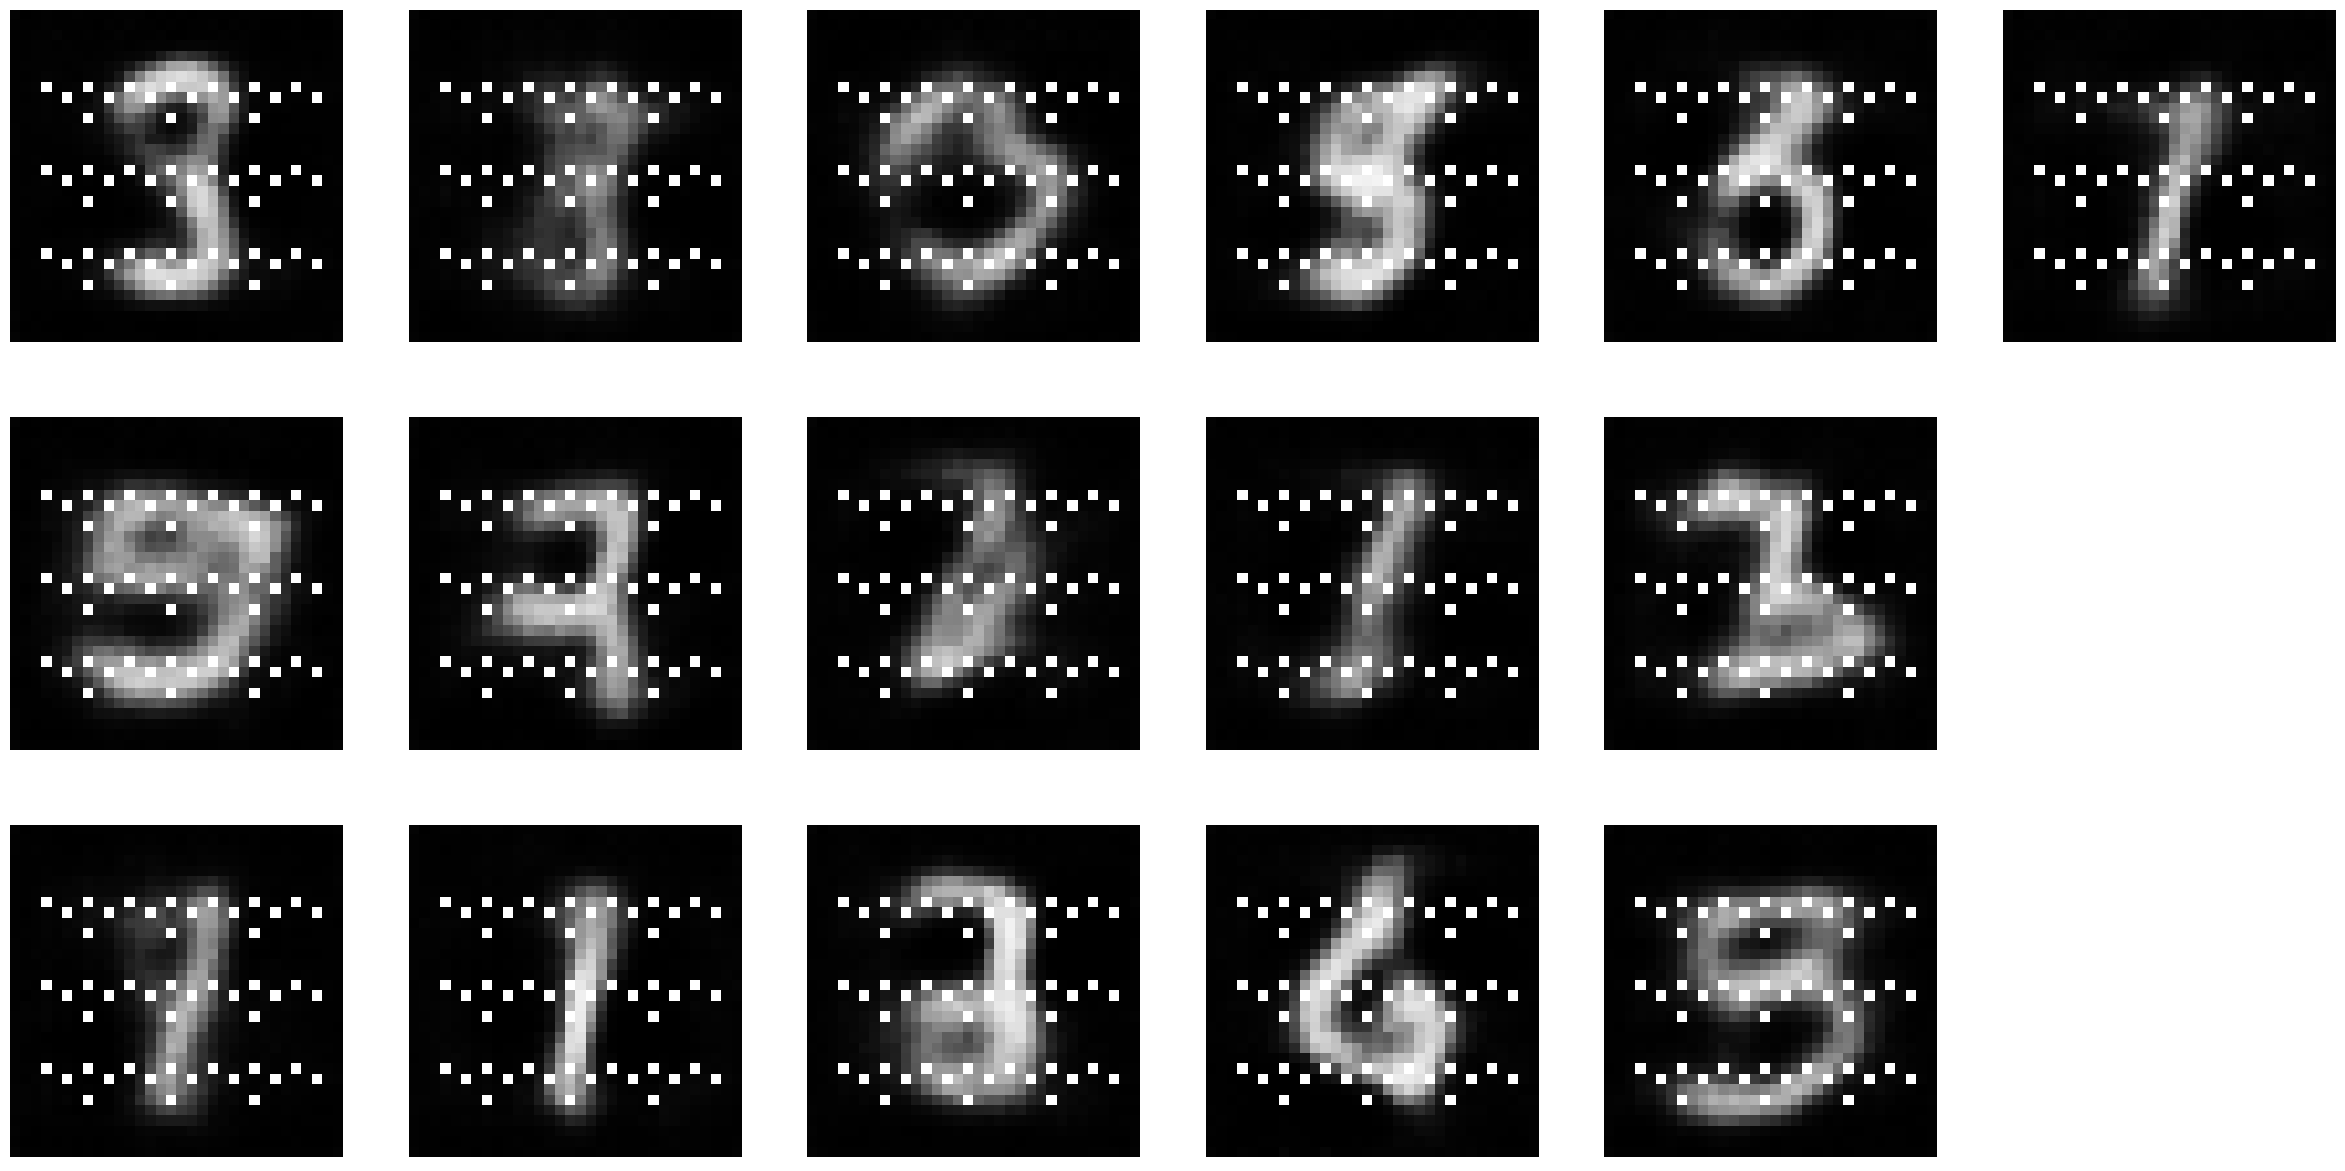

Iter 469/469 [Epoch 6/20] KL_z1 = 3.9193  KL_z2c = 9.6759  KL_c = -186.4558  L2 = 54.2726: : 469it [00:10, 44.22it/s]
Iter 469/469 [Epoch 7/20] KL_z1 = 3.9205  KL_z2c = 9.8179  KL_c = -185.8632  L2 = 49.2209: : 469it [00:09, 47.37it/s]
Iter 469/469 [Epoch 8/20] KL_z1 = 3.9524  KL_z2c = 9.9548  KL_c = -185.1462  L2 = 46.6627: : 469it [00:08, 54.33it/s]
Iter 469/469 [Epoch 9/20] KL_z1 = 3.9412  KL_z2c = 9.9417  KL_c = -184.3094  L2 = 46.1219: : 469it [00:10, 45.85it/s]


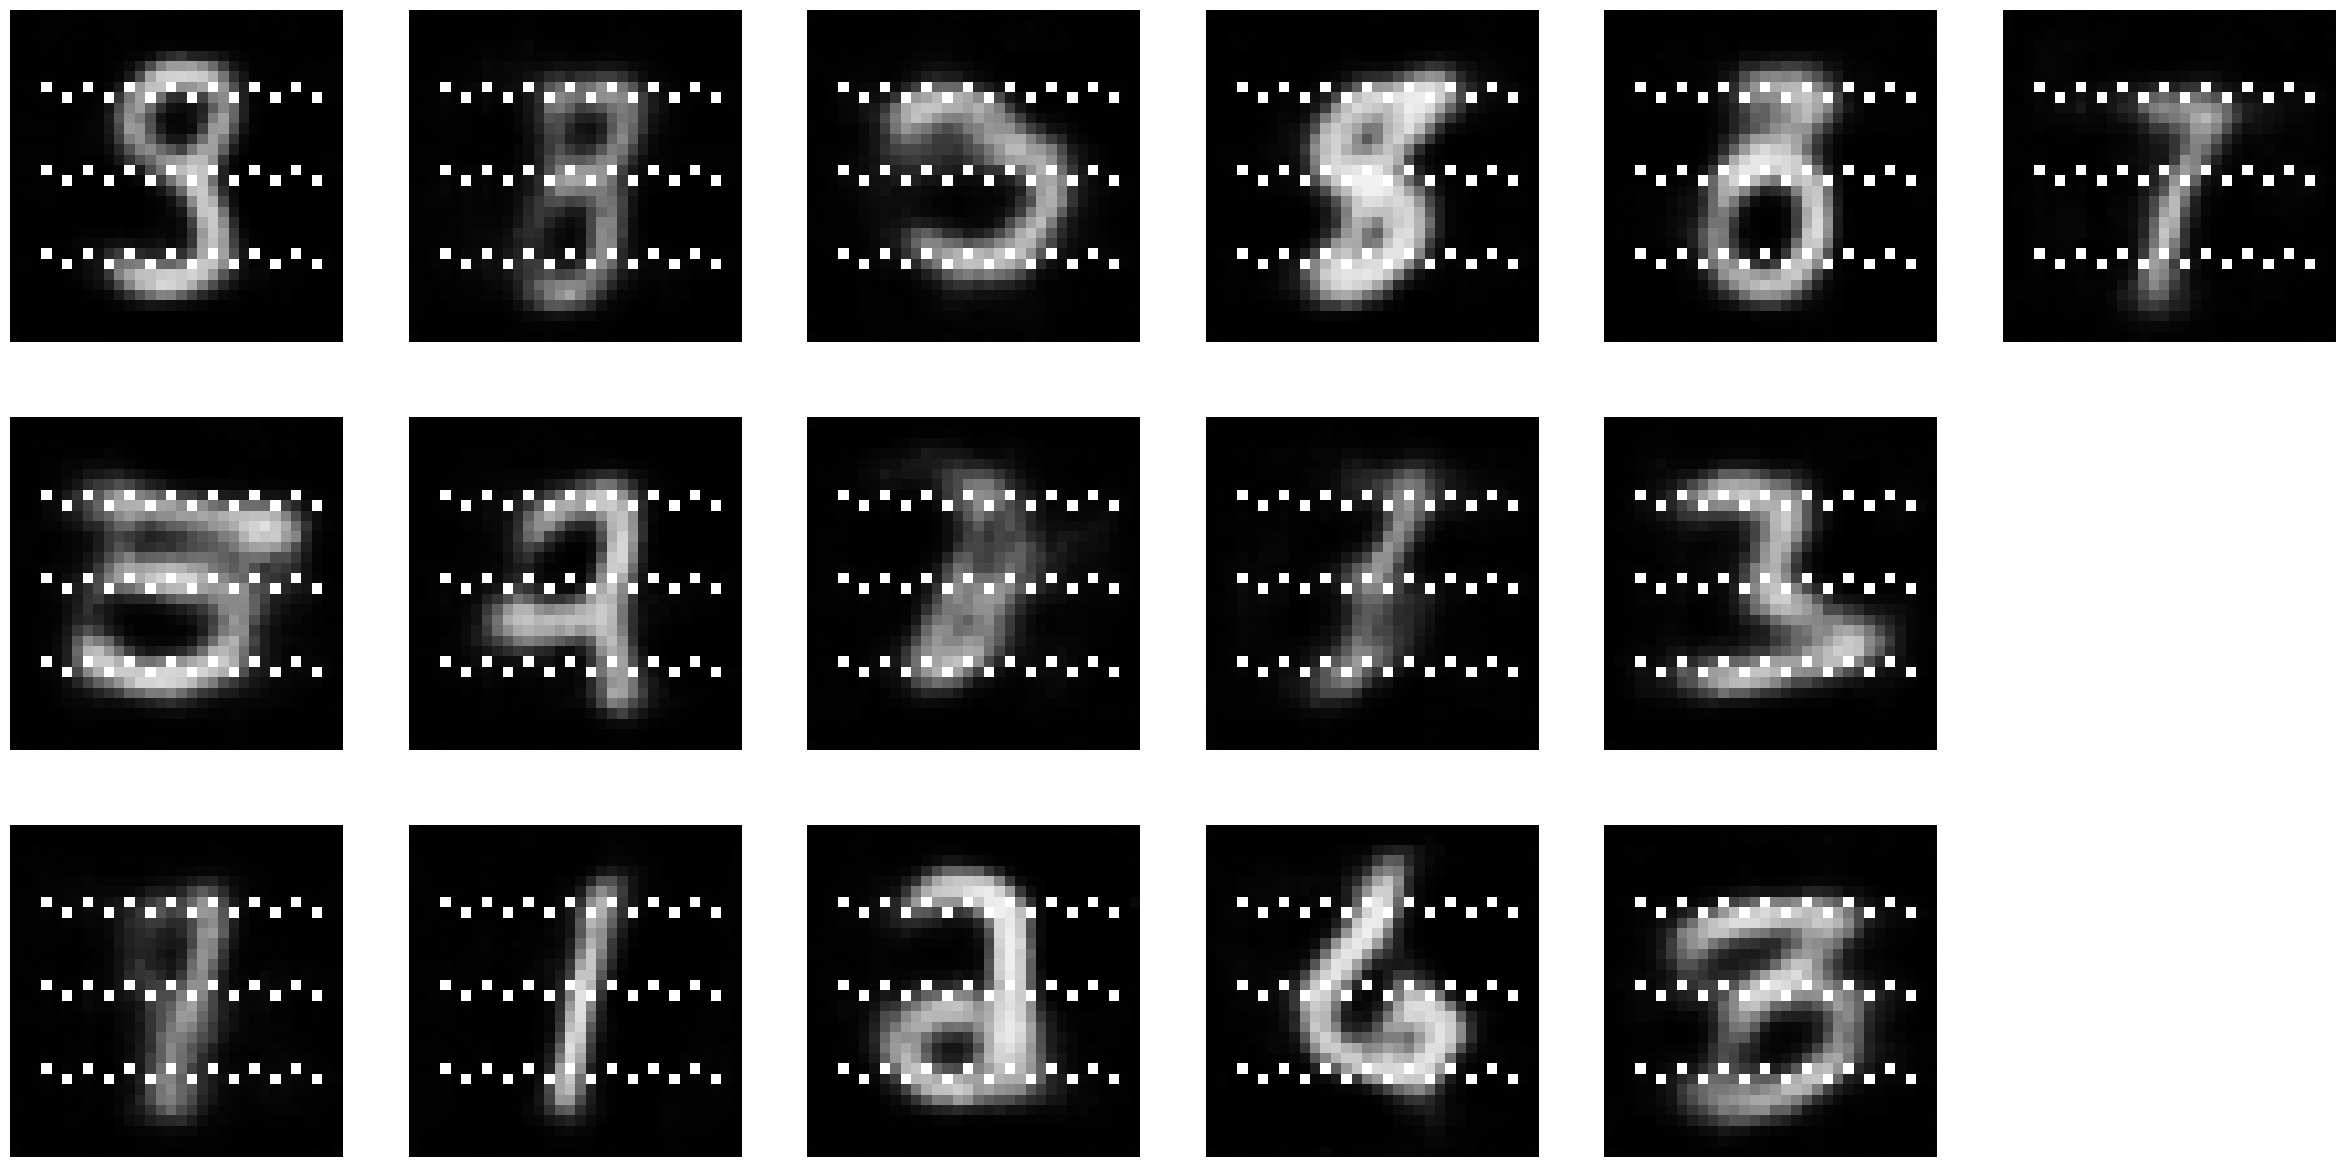

Iter 469/469 [Epoch 10/20] KL_z1 = 3.9532  KL_z2c = 9.9490  KL_c = -183.4194  L2 = 45.7358: : 469it [00:10, 45.51it/s]
Iter 469/469 [Epoch 11/20] KL_z1 = 3.9510  KL_z2c = 9.9791  KL_c = -182.5545  L2 = 45.3845: : 469it [00:09, 46.98it/s]
Iter 469/469 [Epoch 12/20] KL_z1 = 3.9612  KL_z2c = 9.9618  KL_c = -181.6051  L2 = 45.1229: : 469it [00:10, 46.28it/s]
Iter 469/469 [Epoch 13/20] KL_z1 = 3.9699  KL_z2c = 9.9175  KL_c = -180.7559  L2 = 44.8736: : 469it [00:10, 46.42it/s]


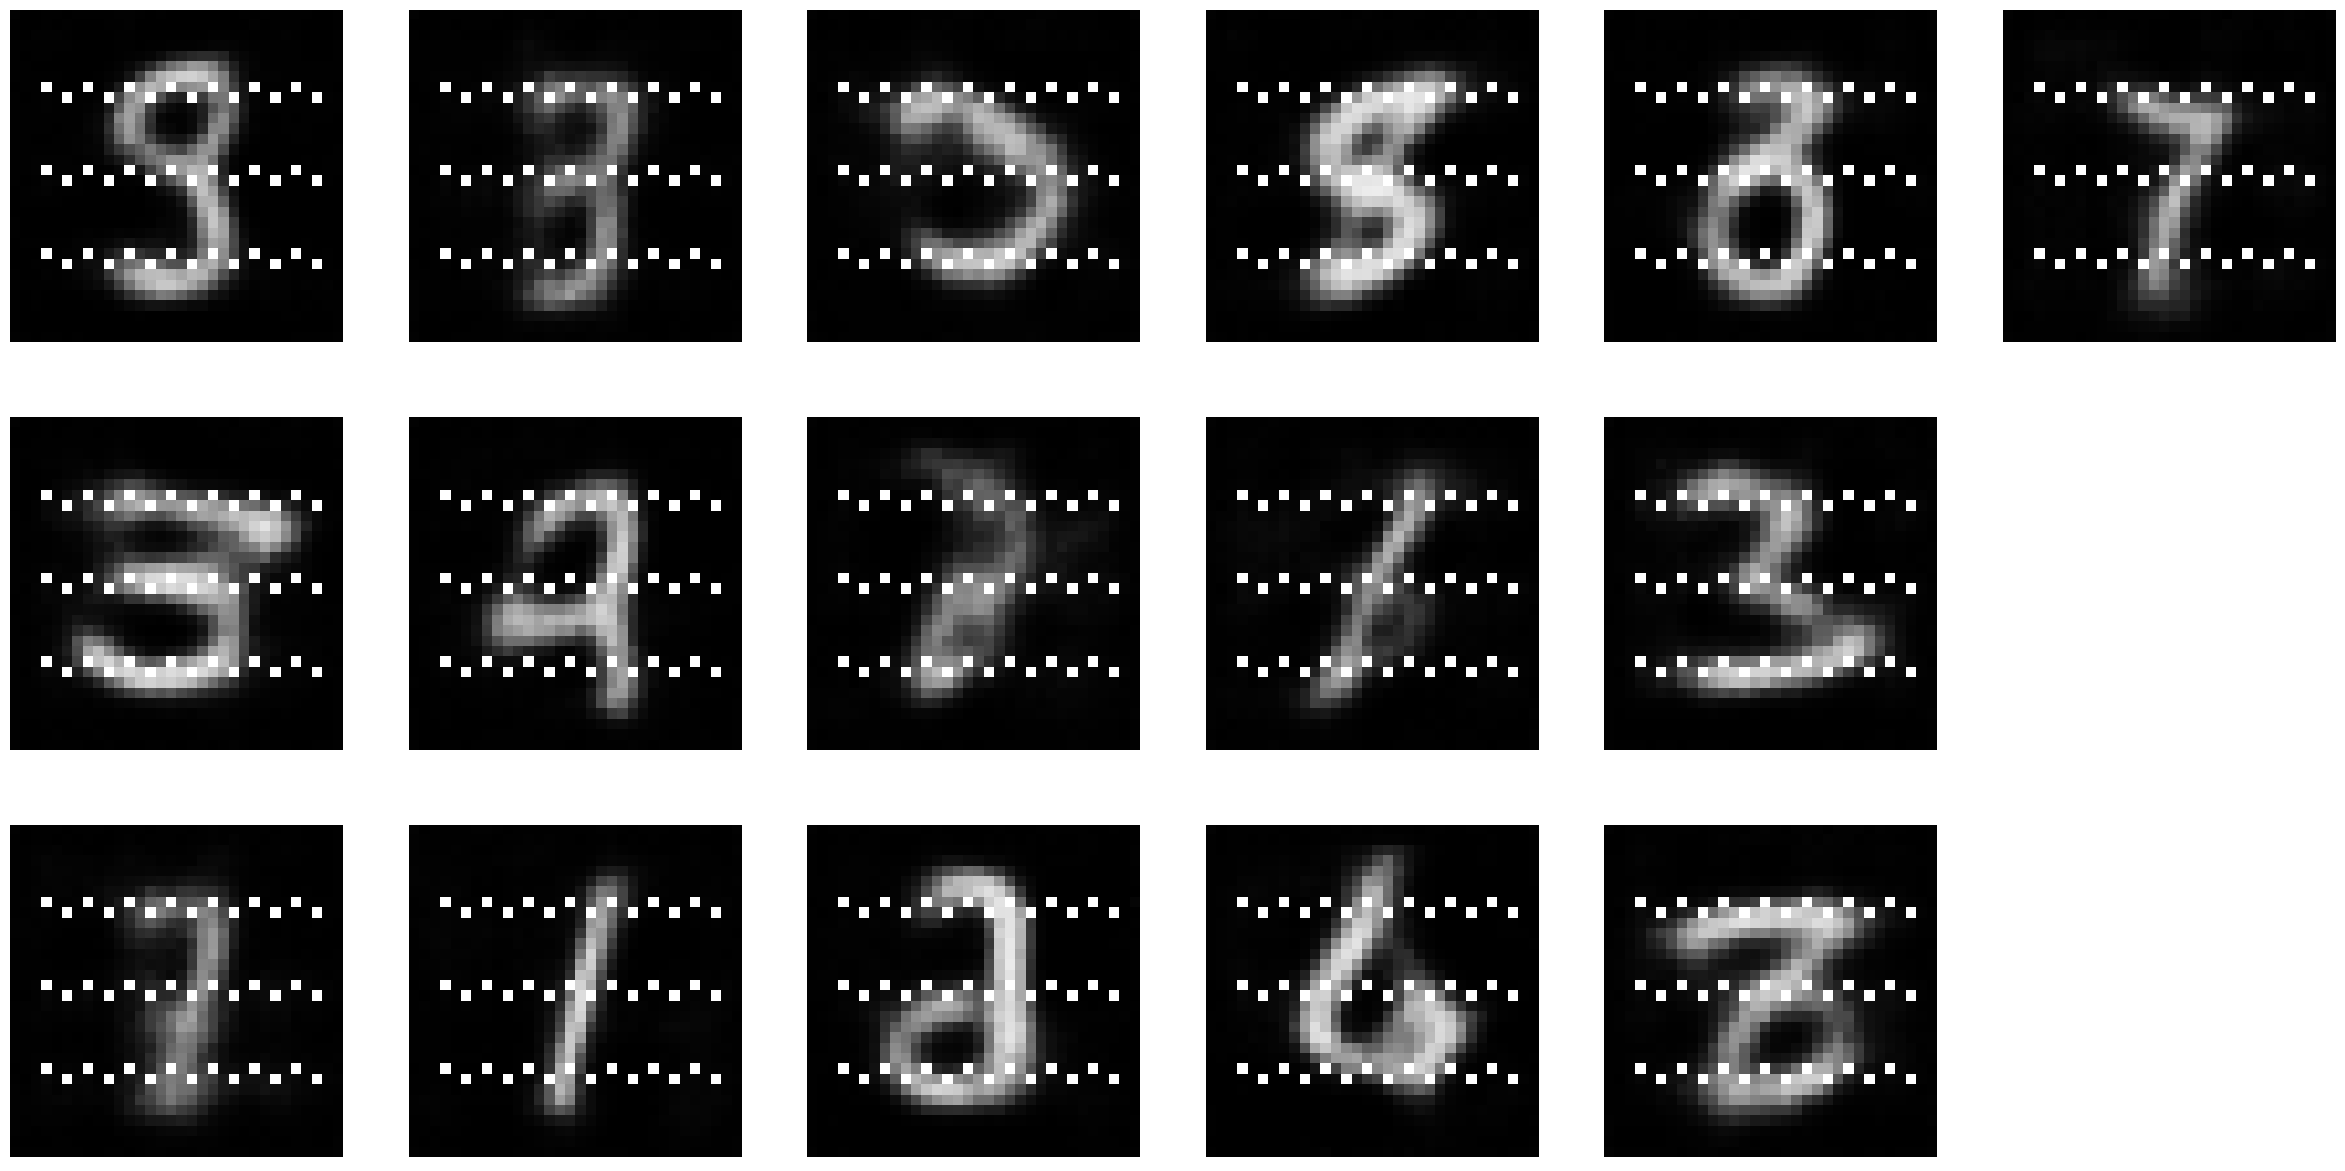

Iter 469/469 [Epoch 14/20] KL_z1 = 3.9808  KL_z2c = 10.1896  KL_c = -179.7493  L2 = 23.2266: : 469it [00:09, 47.47it/s]
Iter 469/469 [Epoch 15/20] KL_z1 = 3.9739  KL_z2c = 10.3517  KL_c = -178.6547  L2 = 14.4574: : 469it [00:10, 46.82it/s]
Iter 469/469 [Epoch 16/20] KL_z1 = 3.9873  KL_z2c = 10.3452  KL_c = -177.7226  L2 = 14.1245: : 469it [00:13, 35.98it/s]
Iter 469/469 [Epoch 17/20] KL_z1 = 3.9799  KL_z2c = 10.3663  KL_c = -176.8462  L2 = 13.8920: : 469it [00:11, 40.81it/s]


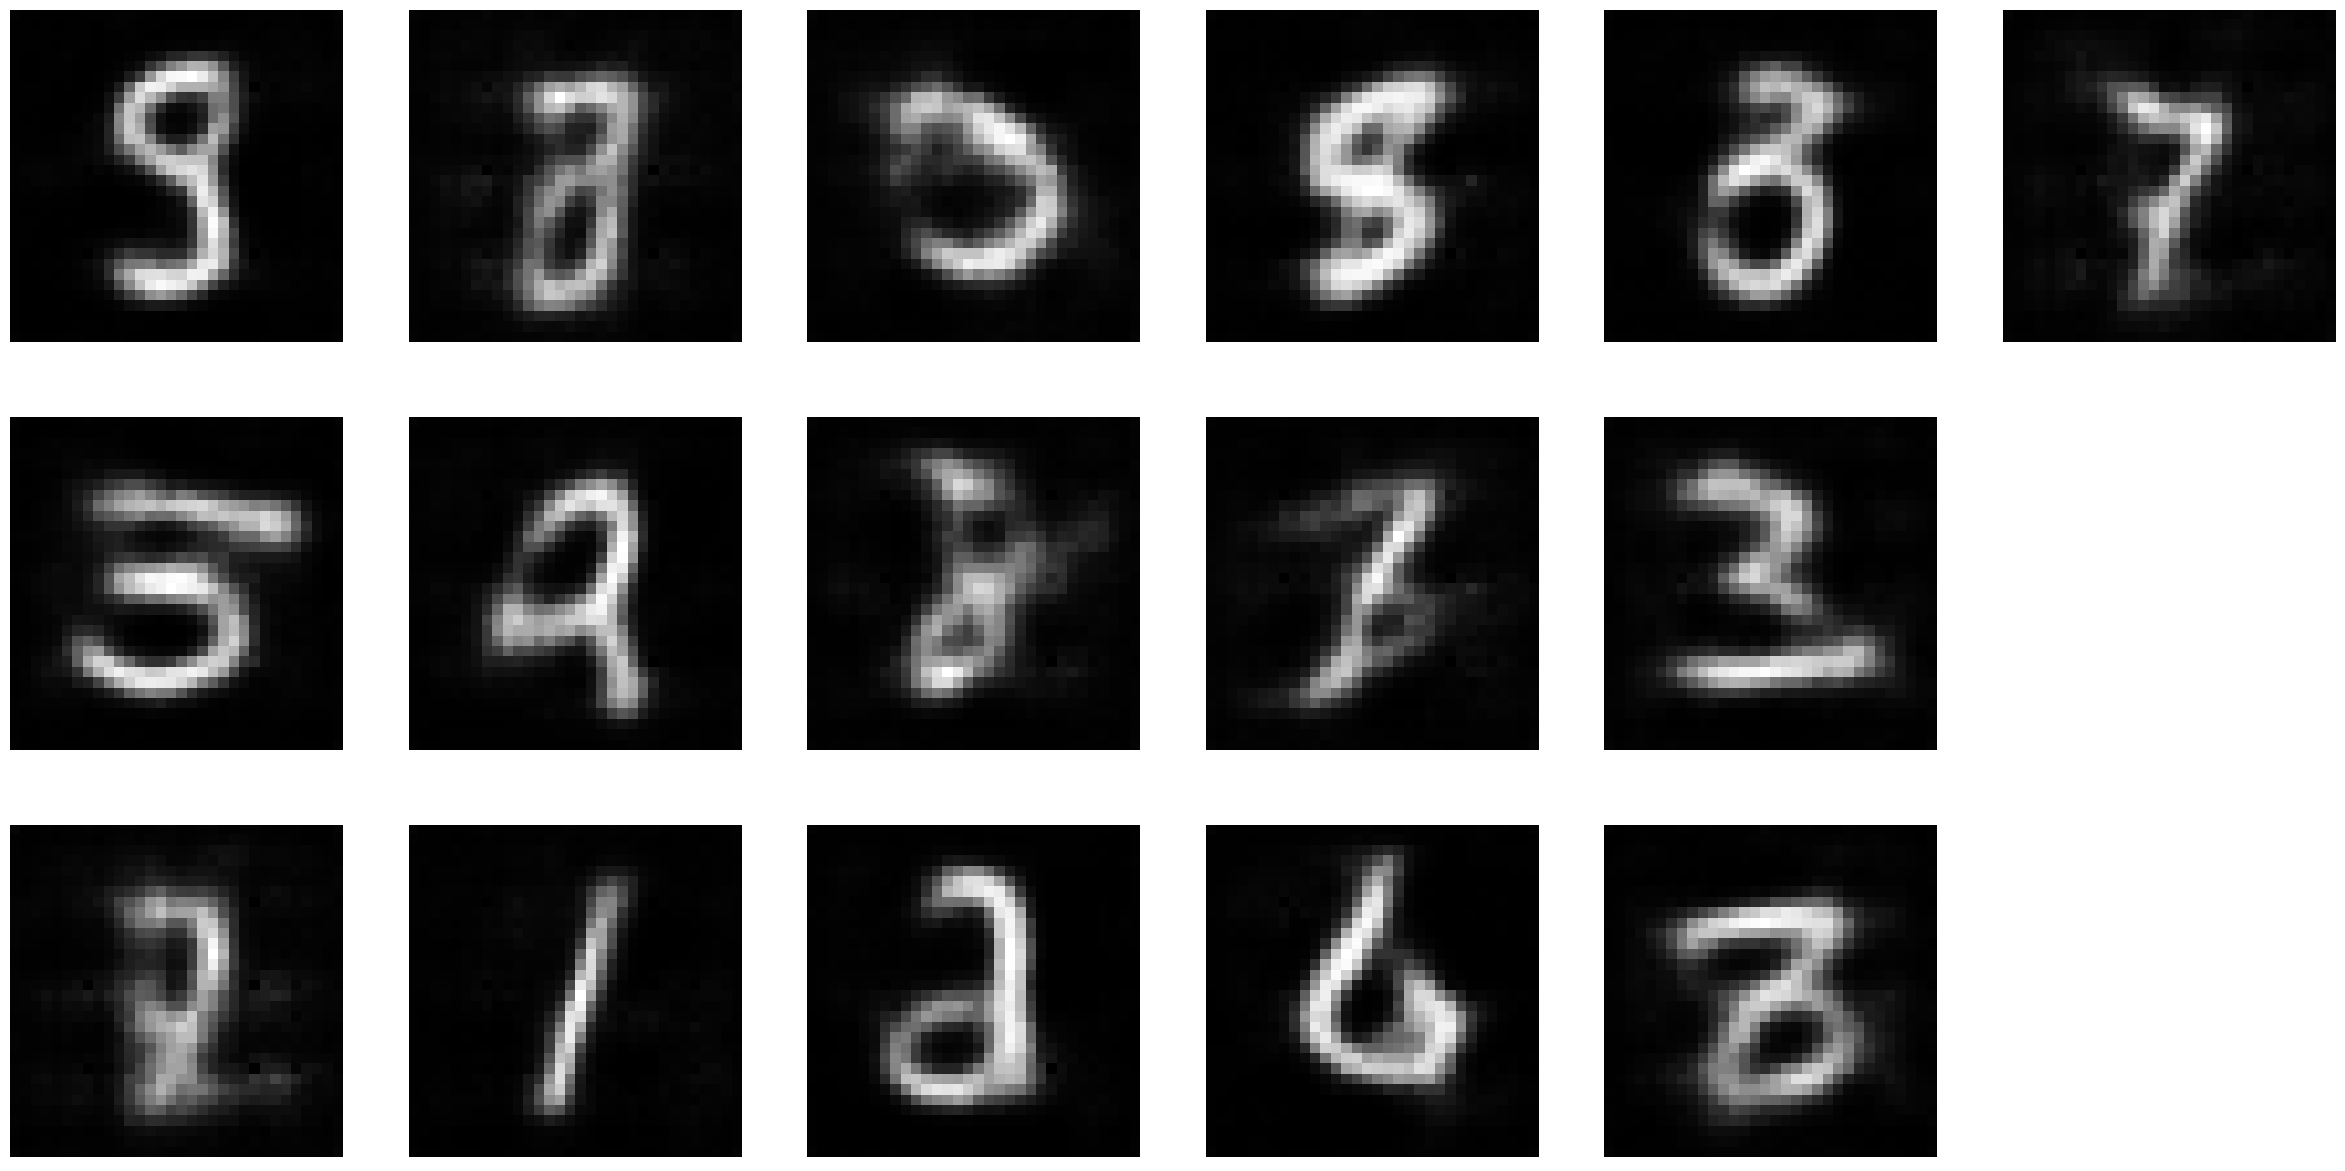

Iter 469/469 [Epoch 18/20] KL_z1 = 3.9823  KL_z2c = 10.3447  KL_c = -175.9236  L2 = 13.7290: : 469it [00:10, 44.70it/s]
Iter 469/469 [Epoch 19/20] KL_z1 = 3.9704  KL_z2c = 10.3395  KL_c = -175.0718  L2 = 13.5674: : 469it [00:10, 44.57it/s]
Iter 469/469 [Epoch 20/20] KL_z1 = 3.9828  KL_z2c = 10.2940  KL_c = -174.1901  L2 = 13.4259: : 469it [00:10, 46.13it/s]


In [ ]:
visualize_noise = torch.randn(16, latent_size, 1, 1).float().to(device)

for epoch in range(num_epochs):
    pbar = tqdm(enumerate(data_loader))
    enc.train()
    dec.train()
    count = 0
    kl_z1_sum = 0
    kl_z2c_sum = 0
    kl_c_sum = 0
    l2_sum = 0
    for i, (data, _) in pbar:
        optimizer.zero_grad()
        x = data.to(device)
        b = x.shape[0]
        z1, c_onehot, z2 = enc(x, normal_generator)
        reconstructed = dec(z2.view(b, latent_size, 1, 1))

        kl_z1 = enc.kl_z1
        kl_z2c = enc.kl_z2c
        kl_c = enc.kl_c
        l2_loss = ((reconstructed - x) ** 2).sum()
        vae_loss = l2_loss
        # god whispered these magic thresholds to me
        if kl_z1.item() >= 500:
            vae_loss = vae_loss + kl_z1
        if kl_z2c.item() >= 500:
            vae_loss = vae_loss + kl_z2c
        if kl_c.item() >= -1000:
            vae_loss = vae_loss + kl_c

        vae_loss.backward()
        optimizer.step()

        count += b
        kl_z1_sum += kl_z1.item()
        kl_z2c_sum += kl_z2c.item()
        kl_c_sum += kl_c.item()
        l2_sum += l2_loss.item()

        kl_z1_show = '{:.4f}'.format(kl_z1_sum / count)
        kl_z2c_show = '{:.4f}'.format(kl_z2c_sum / count)
        kl_c_show = '{:.4f}'.format(kl_c_sum / count)
        l2_loss_show = '{:.4f}'.format(l2_sum / count)

        pbar.set_description(
            f'Iter {i+1}/{len(data_loader)} [Epoch {epoch+1}/{num_epochs}] '
            f'KL_z1 = {kl_z1_show}  KL_z2c = {kl_z2c_show}  KL_c = {kl_c_show}  L2 = {l2_loss_show}'
        )

    if epoch % 4 == 0:
        with torch.no_grad():
            dec.eval()
            pred = dec(visualize_noise)
            plotter(pred.cpu())

In [ ]:
torch.save({
    "encoder": enc.state_dict(),
    "decoder": dec.state_dict()
}, "weights/gmvae_weights.pt")
# my brother in christ this took forever to debug i'm not letting you go my precious weights mwah mwah 大好きです

## Inference

We do a little trick to get $c$ to condition $z_2$. Remember the components that samples $z_2$ from $z_1$ right? This component is trained alongside the main network in real time through `KL_z2c`. Anyways, this allows $z_2$ to alternatively be generated from $z_1$ and $c$ (like we wanted). Here, let me show you